# Figure S4A-D (reverse correlation, rotational)
The goal of this experiment is to estimate the dynamics of the optic flow memory (in the rotational dimension) using noisy velocity inputs and the reverse correlation.

Fish observed cw/ccw stimuli (open-loop) rotating at 60 deg/s that switches directions randomly with a 0.5 Hz Poisson process.

In [2]:
# Import packages
import numpy as np
import os
from bouter import EmbeddedExperiment
from matplotlib import pyplot as plt
from scipy.stats import binned_statistic
import colorcet as cc
from homr_util import *
from tqdm import tqdm

In [3]:
# Tweaking matplotlib 
set_rcParams()

In [4]:
# Find data
data_dir = "./data/figS4_01"
fish_list = os.listdir(data_dir)
n_fish = len(fish_list)
print('total',n_fish,'fish')

total 29 fish


## Analysis
- Average stimuli preceding bout onset, weighted by bout bias (bout-triggered-average, *BTA*)
- A proper reverse correlation analysis would require matrix division by stimulus autocorrelation. We figured the amount of data we have makes it impossible to do this (things get too noisy).

#### Parameters

In [5]:
kernel_shift = 0 # in s
kernel_duration = 15 # in s
kernel_resolution = 5 # in Hz

# prepare vector
kernel_t_vec = np.arange(kernel_duration-kernel_shift, -kernel_shift, -1/kernel_resolution)

# inclusion criteria
min_freq = 0.05      # in Hz, minimum total bout frequency
bias_threshold = 180 # bouts with bias higher than this will not be included

In [7]:
all_BTA = []

for fish in tqdm(fish_list):
    
    # pull out data
    exp = EmbeddedExperiment(data_dir + '/' + fish)
    slog = exp['stimulus']['log']
    bouts = exp.get_bouts()
    
    # proceed only if we have enough bouts
    if len(bouts) >= 60 * 60 * min_freq:
        
        ## pull out time series
        # timestamp
        t_s = exp.stimulus_log['t'].to_numpy()
        # get bouts from bouter
        bsum = exp.get_bout_properties()
        # stimulus (in deg/s)
        stim = exp.stimulus_log['ADPS_drift_direction']  * 60
        # convert bout bias into degree from rad
        bias = bsum['bias'].to_numpy() * 180 / np.pi
        # bout timing
        t_bout = bsum['t_start'].to_numpy()

        # remove bouts too early, too late, or too biased
        too_early = t_bout <= kernel_duration - kernel_shift
        too_late  = t_bout > t_s[-1] - kernel_duration + kernel_shift
        too_turny = np.abs(bias)>bias_threshold
        not_too_early_or_late = ~too_early * ~too_late *~too_turny
        
        n_valid_bout = np.sum(not_too_early_or_late)

        # downsample stimulus
        t_edge = np.arange(t_s[0], t_s[-1], 1/kernel_resolution)
        t_cen  = (t_edge[:-1]+t_edge[1:])/2
        ds_stim = binned_statistic(t_s, stim, 'mean', t_edge)[0]
        ind_bout = np.argmin(np.abs(t_bout[not_too_early_or_late,None]-t_cen[None,:]),axis=1)

        # create 2d array for indexes corresponding to the stimulus matrix
        ind_mat = ind_bout[:,None] + np.arange( -(kernel_duration-kernel_shift)*kernel_resolution, kernel_shift*kernel_resolution,)[None,:]

        # stimulus matrix
        s_mat = ds_stim[ind_mat]
        s_mat[np.isnan(s_mat)] = 0

        # Bout triggered averages
        BTA = np.matmul(s_mat.T, bias[not_too_early_or_late]) / n_valid_bout
        
        # log data
        all_BTA.append(BTA)

all_BTA = np.asarray(all_BTA)

100%|████████████████████████████████████████████████████████████████████████| 29/29 [00:26<00:00,  1.09it/s]


In [10]:
## Fitting logistic to individual BTA
# We post hoc decided to use logistic as exponential fails really badly due to the `shoulder` at time 0
n_good_fish = all_BTA.shape[0]
taus = np.empty(n_good_fish)
Ts = np.empty(n_good_fish)
y0s = np.empty(n_good_fish)
for i in range(1, n_good_fish):
    Ts[i], taus[i], y0s[i], _ = fit_logistic(all_BTA[i, :], kernel_duration, kernel_resolution, p0=(1,1,1000))

In [9]:
# Fit logistic on average BTA
mean_BTA = np.mean(all_BTA, axis=0)
mean_T, mean_tau, mean_y0, _ = fit_logistic(mean_BTA, kernel_duration, kernel_resolution)

## Panels
### Fig. S4A (Individual fish example)

In [16]:
fid = 7 # example fish

show_range = (200, 300) # time period that had good number of bouts in both directions

# re-load the raw data (because we did not keep them for the sake of memory)
exp = EmbeddedExperiment(data_dir + '/' + fish_list[fid])
slog = exp['stimulus']['log']
bouts = exp.get_bouts()
bsum = exp.get_bout_properties()

t_s = exp.stimulus_log['t'].to_numpy()
stim = exp.stimulus_log['ADPS_drift_direction'].to_numpy() * 60
t_b = exp.behavior_log['t'].to_numpy()
tail_sum = exp.behavior_log['tail_sum'].to_numpy() * 180 / np.pi

bias = bsum['bias'].to_numpy() * 180 / np.pi
t_bout = bsum['t_start'].to_numpy()

good_bout = (np.abs(bias) <= bias_threshold) * (t_bout > show_range[0]) * (t_bout < show_range[1])

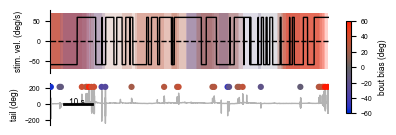

In [17]:
fig, ax = plt.subplots(2, 1, figsize=(4.5, 1.5), height_ratios=(3,2))

cmap = cc.cm.CET_D8
max_bias = 60

# stimulus time trace, with pre-bout period labeled with colored rectangles
ax[0].plot(t_s, stim, color=(0,0,0), zorder=3)
ax[0].plot([0,2000],[0,0],'k--')
box_height = 70
for t_end, this_b in zip(t_bout[good_bout], bias[good_bout]):
    ax[0].fill_between((t_end-kernel_duration, t_end), (box_height, box_height), (-box_height, -box_height), alpha=0.2, color=cmap((this_b+max_bias)/max_bias/2))

# raw tail traces with bouts, colored by bias
ax[1].plot(t_b, tail_sum, lw=1, color=(0.7,0.7,0.7))
sc = ax[1].scatter(t_bout[good_bout], 220 + 0*bias[good_bout], c=bias[good_bout], s=20, cmap=cmap, vmax=max_bias, vmin=-max_bias, zorder=3)
ax[1].plot((show_range[0]+5, show_range[0]+15), [-2,-2], 'k-', lw=2)
ax[1].text(show_range[0]+7, -4, '10 s')
cb = plt.colorbar(sc, ax=ax, location='right', shrink=0.8)
cb.set_label('bout bias (deg)')

# axis management
ax[0].set_xlim(show_range[0], show_range[1])
ax[1].set_xlim(show_range[0], show_range[1])
ax[0].set_ylim(-80, 80)
ax[1].set_ylim(-270, 270)

ax[0].set_ylabel('stim. vel. (deg/s)')
ax[1].set_ylabel('tail (deg)')

toggle_spines(ax[0], 0, 0, 0, 1)
toggle_spines(ax[1], 0, 0, 0, 1)

plt.savefig('./svgs/FigS4A.svg', format='svg')
plt.show()

### Fig. S4B (Example fish BTA with the logistic fit)

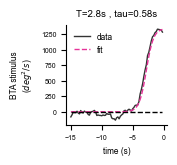

In [18]:
fig, ax = plt.subplots(1,1, figsize=(1.3, 1.3))
ax.plot(-kernel_t_vec, all_BTA[fid, :], color=(0.2,0.2,0.2), label='data')
ax.plot(-kernel_t_vec, logistic(kernel_t_vec, Ts[fid], taus[fid], y0s[fid]), linestyle='--', color=(0.9,0.2,0.6), label='fit')
ax.plot(-kernel_t_vec, kernel_t_vec*0, 'k--')
ax.set_title('T={:0.2}s , tau={:0.2}s'.format(Ts[fid], taus[fid]))
ax.legend()
ax.set_ylabel('BTA stimulus\n($deg^2/s$)')
ax.set_xlabel('time (s)')
toggle_spines(ax, 0, 1, 0, 1)

plt.savefig('./svgs/FigS4B.svg', format='svg')
plt.show()

### Fig. S4CD (Average BTA with the logistic fit & logistic fit paraemters)

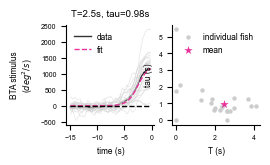

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(2.5, 1.3), width_ratios=(1, 1))

# Individual & average BTA, with fit
ax[0].plot(-kernel_t_vec, mean_BTA, color=(0.2,0.2,0.2), label='data')
ax[0].plot(-kernel_t_vec, all_BTA.T, color=(0.8,0.8,0.8), alpha=0.5, lw=0.5)
ax[0].plot(-kernel_t_vec, logistic(kernel_t_vec, mean_T, mean_tau, mean_y0), linestyle='--', color=(0.9,0.2,0.6), label='fit')
ax[0].plot(-kernel_t_vec, kernel_t_vec*0, 'k--')
ax[0].set_title('T={:0.2}s, tau={:0.2}s'.format(mean_T, mean_tau))
ax[0].legend()

# Fit parameters
ax[1].scatter(Ts[~np.isnan(Ts)], taus[~np.isnan(Ts)], s=10, color=(0.8, 0.8, 0.8), label='individual fish')
ax[1].scatter(mean_T, mean_tau, marker='*', s=40, color=(0.9,0.2,0.6), label='mean')
ax[1].set_xlabel('T (s)')
ax[1].set_ylabel('tau (s)')
ax[1].legend()

ax[0].set_ylabel('BTA stimulus\n($deg^2/s$)')
ax[0].set_xlabel('time (s)')

for axx in ax:
    toggle_spines(axx, 0, 1, 0, 1)
    
plt.savefig('./svgs/FigS4CD.svg', format='svg')
plt.show()